In [1]:
# import all libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import argparse
from swd_optim import *

In [2]:
import torch
torch.cuda.empty_cache()

In [3]:
torch.__version__

'1.9.1'

In [4]:
import os, ssl
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and getattr(ssl, '_create_unverified_context', None)):
    ssl._create_default_https_context = ssl._create_unverified_context

In [5]:
# these are commonly used data augmentations
# random cropping and random horizontal flip
# lastly, we normalize each channel into zero mean and unit standard deviation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)

# we can use a larger batch size during test, because we do not save 
# intermediate variables for gradient computation, which leaves more memory
testloader = torch.utils.data.DataLoader(
    testset, batch_size=256, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [6]:
# Training
def train(epoch, net, criterion, trainloader,scheduler):
    device = 'cuda'
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    

    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        if (batch_idx+1) % 50 == 0:
            print("iteration : %3d, loss : %0.4f, accuracy : %2.2f" % (batch_idx+1, train_loss/(batch_idx+1), 100.*correct/total))

    scheduler.step()
    return train_loss/(batch_idx+1), 100.*correct/total

In [7]:
def test(epoch, net, criterion, testloader):
    device = 'cuda'
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    
    with torch.inference_mode():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            #inputs.requires_grad = True
            outputs = net(inputs)

            loss= criterion(outputs, targets)
            #R = reg(inputs, outputs)   # Jacobian regularization
            #loss = loss_super + lambda_JR*R # full loss
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    return test_loss/(batch_idx+1), 100.*correct/total



In [8]:
def save_checkpoint(net, acc, epoch):
    # Save checkpoint.
    print('Saving..')
    state = {
        'net': net.state_dict(),
        'acc': acc,
        'epoch': epoch,
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/ckpt.pth')





In [9]:
# defining resnet models

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        # This is the "stem"
        # For CIFAR (32x32 images), it does not perform downsampling
        # It should downsample for ImageNet
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        # four stages with three downsampling
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


def test_resnet18():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())


In [10]:
# main body
config = {
    'lr': 0.01,
    'momentum': 0.9,
    'weight_decay': 5e-4
}

train_loss_list = []
train_acc_list  = []
test_loss_list  = []
test_acc_list  = []


net = ResNet18().to('cuda')
criterion = nn.CrossEntropyLoss().to('cuda')
#optimizer = optim.SGD(net.parameters(), lr=config['lr'],
                      #momentum=config['momentum'], weight_decay=config['weight_decay'])

optimizer = AdamS(net.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-08, weight_decay=5e-4, amsgrad=False)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
#print(scheduler)
for epoch in range(0, 200):
    
    train_loss, train_acc = train(epoch, net, criterion, trainloader,scheduler)
    test_loss, test_acc = test(epoch, net, criterion, testloader)
    
    print(("Epoch : %3d, training loss : %0.4f, training accuracy : %2.2f, test loss " + \
      ": %0.4f, test accuracy : %2.2f") % (epoch, train_loss, train_acc, test_loss, test_acc))
    
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    


Epoch: 0
iteration :  50, loss : 1.9694, accuracy : 28.11
iteration : 100, loss : 1.8049, accuracy : 33.30
iteration : 150, loss : 1.7243, accuracy : 36.07
iteration : 200, loss : 1.6477, accuracy : 39.20
iteration : 250, loss : 1.5856, accuracy : 41.75
iteration : 300, loss : 1.5312, accuracy : 43.76
iteration : 350, loss : 1.4833, accuracy : 45.62
Epoch :   0, training loss : 1.4470, training accuracy : 46.97, test loss : 1.1887, test accuracy : 57.38

Epoch: 1
iteration :  50, loss : 1.0623, accuracy : 62.53
iteration : 100, loss : 1.0465, accuracy : 62.69
iteration : 150, loss : 1.0371, accuracy : 63.26
iteration : 200, loss : 1.0186, accuracy : 63.93
iteration : 250, loss : 1.0093, accuracy : 64.03
iteration : 300, loss : 0.9968, accuracy : 64.54
iteration : 350, loss : 0.9828, accuracy : 65.08
Epoch :   1, training loss : 0.9731, training accuracy : 65.45, test loss : 1.1821, test accuracy : 60.65

Epoch: 2
iteration :  50, loss : 0.8229, accuracy : 71.33
iteration : 100, loss :

iteration :  50, loss : 0.3464, accuracy : 88.11
iteration : 100, loss : 0.3369, accuracy : 88.46
iteration : 150, loss : 0.3458, accuracy : 88.16
iteration : 200, loss : 0.3450, accuracy : 88.25
iteration : 250, loss : 0.3424, accuracy : 88.36
iteration : 300, loss : 0.3394, accuracy : 88.46
iteration : 350, loss : 0.3401, accuracy : 88.44
Epoch :  18, training loss : 0.3432, training accuracy : 88.36, test loss : 0.5363, test accuracy : 82.95

Epoch: 19
iteration :  50, loss : 0.3148, accuracy : 89.73
iteration : 100, loss : 0.3019, accuracy : 90.01
iteration : 150, loss : 0.3099, accuracy : 89.58
iteration : 200, loss : 0.3200, accuracy : 89.27
iteration : 250, loss : 0.3299, accuracy : 88.94
iteration : 300, loss : 0.3308, accuracy : 88.89
iteration : 350, loss : 0.3321, accuracy : 88.84
Epoch :  19, training loss : 0.3314, training accuracy : 88.82, test loss : 0.5241, test accuracy : 82.99

Epoch: 20
iteration :  50, loss : 0.3203, accuracy : 89.47
iteration : 100, loss : 0.3211,

iteration :  50, loss : 0.2403, accuracy : 91.72
iteration : 100, loss : 0.2425, accuracy : 91.66
iteration : 150, loss : 0.2501, accuracy : 91.44
iteration : 200, loss : 0.2505, accuracy : 91.37
iteration : 250, loss : 0.2499, accuracy : 91.44
iteration : 300, loss : 0.2510, accuracy : 91.38
iteration : 350, loss : 0.2552, accuracy : 91.25
Epoch :  36, training loss : 0.2560, training accuracy : 91.25, test loss : 0.5953, test accuracy : 82.02

Epoch: 37
iteration :  50, loss : 0.2534, accuracy : 91.64
iteration : 100, loss : 0.2498, accuracy : 91.80
iteration : 150, loss : 0.2483, accuracy : 91.79
iteration : 200, loss : 0.2465, accuracy : 91.74
iteration : 250, loss : 0.2497, accuracy : 91.63
iteration : 300, loss : 0.2532, accuracy : 91.46
iteration : 350, loss : 0.2556, accuracy : 91.38
Epoch :  37, training loss : 0.2557, training accuracy : 91.35, test loss : 0.4576, test accuracy : 84.84

Epoch: 38
iteration :  50, loss : 0.2238, accuracy : 92.17
iteration : 100, loss : 0.2306,

iteration :  50, loss : 0.2046, accuracy : 92.84
iteration : 100, loss : 0.1951, accuracy : 93.28
iteration : 150, loss : 0.1970, accuracy : 93.31
iteration : 200, loss : 0.2024, accuracy : 93.09
iteration : 250, loss : 0.2096, accuracy : 92.80
iteration : 300, loss : 0.2117, accuracy : 92.72
iteration : 350, loss : 0.2122, accuracy : 92.71
Epoch :  54, training loss : 0.2111, training accuracy : 92.74, test loss : 0.3639, test accuracy : 87.96

Epoch: 55
iteration :  50, loss : 0.2055, accuracy : 93.20
iteration : 100, loss : 0.2063, accuracy : 93.05
iteration : 150, loss : 0.2103, accuracy : 92.86
iteration : 200, loss : 0.2123, accuracy : 92.77
iteration : 250, loss : 0.2149, accuracy : 92.65
iteration : 300, loss : 0.2162, accuracy : 92.63
iteration : 350, loss : 0.2206, accuracy : 92.46
Epoch :  55, training loss : 0.2203, training accuracy : 92.48, test loss : 0.3026, test accuracy : 89.95

Epoch: 56
iteration :  50, loss : 0.1633, accuracy : 94.47
iteration : 100, loss : 0.1771,

iteration :  50, loss : 0.1691, accuracy : 94.19
iteration : 100, loss : 0.1656, accuracy : 94.41
iteration : 150, loss : 0.1624, accuracy : 94.57
iteration : 200, loss : 0.1634, accuracy : 94.45
iteration : 250, loss : 0.1686, accuracy : 94.23
iteration : 300, loss : 0.1720, accuracy : 94.12
iteration : 350, loss : 0.1745, accuracy : 94.02
Epoch :  72, training loss : 0.1737, training accuracy : 94.06, test loss : 0.4247, test accuracy : 87.61

Epoch: 73
iteration :  50, loss : 0.1384, accuracy : 95.34
iteration : 100, loss : 0.1442, accuracy : 95.10
iteration : 150, loss : 0.1493, accuracy : 94.85
iteration : 200, loss : 0.1591, accuracy : 94.57
iteration : 250, loss : 0.1624, accuracy : 94.46
iteration : 300, loss : 0.1638, accuracy : 94.43
iteration : 350, loss : 0.1646, accuracy : 94.38
Epoch :  73, training loss : 0.1666, training accuracy : 94.32, test loss : 0.3793, test accuracy : 88.29

Epoch: 74
iteration :  50, loss : 0.1698, accuracy : 94.12
iteration : 100, loss : 0.1611,

iteration :  50, loss : 0.1230, accuracy : 95.81
iteration : 100, loss : 0.1186, accuracy : 95.93
iteration : 150, loss : 0.1202, accuracy : 95.81
iteration : 200, loss : 0.1201, accuracy : 95.86
iteration : 250, loss : 0.1240, accuracy : 95.68
iteration : 300, loss : 0.1262, accuracy : 95.61
iteration : 350, loss : 0.1279, accuracy : 95.55
Epoch :  90, training loss : 0.1300, training accuracy : 95.50, test loss : 0.3205, test accuracy : 90.62

Epoch: 91
iteration :  50, loss : 0.1296, accuracy : 95.72
iteration : 100, loss : 0.1292, accuracy : 95.70
iteration : 150, loss : 0.1311, accuracy : 95.64
iteration : 200, loss : 0.1310, accuracy : 95.55
iteration : 250, loss : 0.1302, accuracy : 95.59
iteration : 300, loss : 0.1289, accuracy : 95.60
iteration : 350, loss : 0.1300, accuracy : 95.54
Epoch :  91, training loss : 0.1308, training accuracy : 95.50, test loss : 0.3767, test accuracy : 89.44

Epoch: 92
iteration :  50, loss : 0.1187, accuracy : 96.09
iteration : 100, loss : 0.1199,

iteration :  50, loss : 0.0772, accuracy : 97.50
iteration : 100, loss : 0.0806, accuracy : 97.24
iteration : 150, loss : 0.0848, accuracy : 97.09
iteration : 200, loss : 0.0867, accuracy : 96.94
iteration : 250, loss : 0.0885, accuracy : 96.86
iteration : 300, loss : 0.0907, accuracy : 96.76
iteration : 350, loss : 0.0943, accuracy : 96.69
Epoch : 108, training loss : 0.0936, training accuracy : 96.71, test loss : 0.2902, test accuracy : 91.27

Epoch: 109
iteration :  50, loss : 0.0748, accuracy : 97.27
iteration : 100, loss : 0.0753, accuracy : 97.47
iteration : 150, loss : 0.0802, accuracy : 97.29
iteration : 200, loss : 0.0837, accuracy : 97.17
iteration : 250, loss : 0.0855, accuracy : 97.10
iteration : 300, loss : 0.0864, accuracy : 97.09
iteration : 350, loss : 0.0867, accuracy : 97.08
Epoch : 109, training loss : 0.0865, training accuracy : 97.06, test loss : 0.2967, test accuracy : 91.42

Epoch: 110
iteration :  50, loss : 0.0900, accuracy : 96.91
iteration : 100, loss : 0.094

iteration :  50, loss : 0.0474, accuracy : 98.44
iteration : 100, loss : 0.0472, accuracy : 98.36
iteration : 150, loss : 0.0504, accuracy : 98.24
iteration : 200, loss : 0.0519, accuracy : 98.21
iteration : 250, loss : 0.0515, accuracy : 98.24
iteration : 300, loss : 0.0522, accuracy : 98.21
iteration : 350, loss : 0.0534, accuracy : 98.15
Epoch : 126, training loss : 0.0542, training accuracy : 98.12, test loss : 0.3098, test accuracy : 91.87

Epoch: 127
iteration :  50, loss : 0.0419, accuracy : 98.75
iteration : 100, loss : 0.0431, accuracy : 98.66
iteration : 150, loss : 0.0475, accuracy : 98.49
iteration : 200, loss : 0.0499, accuracy : 98.33
iteration : 250, loss : 0.0518, accuracy : 98.25
iteration : 300, loss : 0.0547, accuracy : 98.14
iteration : 350, loss : 0.0565, accuracy : 98.09
Epoch : 127, training loss : 0.0570, training accuracy : 98.07, test loss : 0.2912, test accuracy : 92.02

Epoch: 128
iteration :  50, loss : 0.0499, accuracy : 98.22
iteration : 100, loss : 0.052

iteration :  50, loss : 0.0274, accuracy : 99.11
iteration : 100, loss : 0.0283, accuracy : 99.07
iteration : 150, loss : 0.0277, accuracy : 99.11
iteration : 200, loss : 0.0278, accuracy : 99.11
iteration : 250, loss : 0.0288, accuracy : 99.08
iteration : 300, loss : 0.0300, accuracy : 99.03
iteration : 350, loss : 0.0301, accuracy : 99.01
Epoch : 144, training loss : 0.0298, training accuracy : 99.03, test loss : 0.2768, test accuracy : 92.83

Epoch: 145
iteration :  50, loss : 0.0228, accuracy : 99.14
iteration : 100, loss : 0.0254, accuracy : 99.05
iteration : 150, loss : 0.0258, accuracy : 99.09
iteration : 200, loss : 0.0253, accuracy : 99.12
iteration : 250, loss : 0.0247, accuracy : 99.14
iteration : 300, loss : 0.0244, accuracy : 99.18
iteration : 350, loss : 0.0248, accuracy : 99.17
Epoch : 145, training loss : 0.0251, training accuracy : 99.16, test loss : 0.2941, test accuracy : 92.66

Epoch: 146
iteration :  50, loss : 0.0211, accuracy : 99.38
iteration : 100, loss : 0.022

iteration :  50, loss : 0.0094, accuracy : 99.81
iteration : 100, loss : 0.0080, accuracy : 99.79
iteration : 150, loss : 0.0091, accuracy : 99.76
iteration : 200, loss : 0.0100, accuracy : 99.71
iteration : 250, loss : 0.0100, accuracy : 99.71
iteration : 300, loss : 0.0095, accuracy : 99.72
iteration : 350, loss : 0.0094, accuracy : 99.72
Epoch : 162, training loss : 0.0093, training accuracy : 99.72, test loss : 0.2545, test accuracy : 94.14

Epoch: 163
iteration :  50, loss : 0.0091, accuracy : 99.67
iteration : 100, loss : 0.0081, accuracy : 99.73
iteration : 150, loss : 0.0080, accuracy : 99.73
iteration : 200, loss : 0.0082, accuracy : 99.72
iteration : 250, loss : 0.0082, accuracy : 99.73
iteration : 300, loss : 0.0086, accuracy : 99.72
iteration : 350, loss : 0.0088, accuracy : 99.72
Epoch : 163, training loss : 0.0085, training accuracy : 99.73, test loss : 0.2654, test accuracy : 93.83

Epoch: 164
iteration :  50, loss : 0.0072, accuracy : 99.83
iteration : 100, loss : 0.006

iteration :  50, loss : 0.0008, accuracy : 100.00
iteration : 100, loss : 0.0007, accuracy : 100.00
iteration : 150, loss : 0.0011, accuracy : 99.98
iteration : 200, loss : 0.0011, accuracy : 99.98
iteration : 250, loss : 0.0012, accuracy : 99.98
iteration : 300, loss : 0.0011, accuracy : 99.98
iteration : 350, loss : 0.0011, accuracy : 99.98
Epoch : 180, training loss : 0.0011, training accuracy : 99.98, test loss : 0.2346, test accuracy : 94.94

Epoch: 181
iteration :  50, loss : 0.0012, accuracy : 99.97
iteration : 100, loss : 0.0011, accuracy : 99.98
iteration : 150, loss : 0.0011, accuracy : 99.98
iteration : 200, loss : 0.0010, accuracy : 99.98
iteration : 250, loss : 0.0011, accuracy : 99.98
iteration : 300, loss : 0.0012, accuracy : 99.98
iteration : 350, loss : 0.0012, accuracy : 99.98
Epoch : 181, training loss : 0.0012, training accuracy : 99.98, test loss : 0.2425, test accuracy : 94.86

Epoch: 182
iteration :  50, loss : 0.0008, accuracy : 100.00
iteration : 100, loss : 0.

Epoch : 197, training loss : 0.0004, training accuracy : 100.00, test loss : 0.2206, test accuracy : 95.04

Epoch: 198
iteration :  50, loss : 0.0007, accuracy : 99.98
iteration : 100, loss : 0.0006, accuracy : 99.99
iteration : 150, loss : 0.0005, accuracy : 99.99
iteration : 200, loss : 0.0005, accuracy : 100.00
iteration : 250, loss : 0.0005, accuracy : 100.00
iteration : 300, loss : 0.0005, accuracy : 100.00
iteration : 350, loss : 0.0005, accuracy : 100.00
Epoch : 198, training loss : 0.0005, training accuracy : 100.00, test loss : 0.2236, test accuracy : 94.97

Epoch: 199
iteration :  50, loss : 0.0008, accuracy : 99.98
iteration : 100, loss : 0.0006, accuracy : 99.99
iteration : 150, loss : 0.0006, accuracy : 99.99
iteration : 200, loss : 0.0007, accuracy : 99.99
iteration : 250, loss : 0.0006, accuracy : 99.99
iteration : 300, loss : 0.0006, accuracy : 99.99
iteration : 350, loss : 0.0006, accuracy : 99.99
Epoch : 199, training loss : 0.0006, training accuracy : 99.99, test los

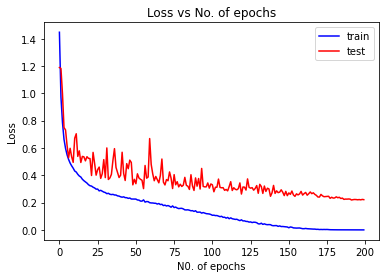

In [11]:
import matplotlib.pyplot as plt
plt.plot(range(len(train_loss_list)), train_loss_list, 'b')
plt.plot(range(len(test_loss_list)), test_loss_list, 'r')

plt.xlabel("N0. of epochs")
plt.ylabel("Loss")
plt.title("Loss vs No. of epochs")
plt.legend(['train', 'test'])
plt.show()

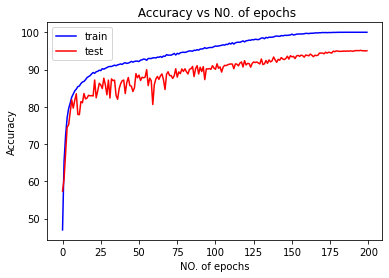

In [12]:
plt.plot(range(len(train_acc_list)), train_acc_list, 'b')
plt.plot(range(len(test_acc_list)), test_acc_list, 'r')
plt.xlabel("NO. of epochs")
plt.ylabel("Accuracy")
plt.title(" Accuracy vs N0. of epochs")
plt.legend(['train', 'test']) 
plt.show()